In [6]:
import time
import torch
import sys
import os
import matplotlib.pyplot as plt

from ase import Atoms
from pynl import NeighbourList

from vesin import ase_neighbor_list as vesin_ase_neighbor_list
from matscipy.neighbours import neighbour_list as matscipy_neighbour_list
from torch_nl import compute_neighborlist, ase2data
from nvalchemiops.neighborlist import neighbor_list

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    'lines.markersize': 4,
    'lines.linewidth': 1.5,  # Increased from 1 to 1.5
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
})

colors = sns.color_palette("deep")

In [8]:
def time_fn(fn, n_tries=10, sync_cuda=False):
    # warmup
    fn()
    if sync_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

    times = []

    for _ in range(n_tries):
        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()
        fn()
        if sync_cuda and torch.cuda.is_available():
            torch.cuda.synchronize()
        end = time.perf_counter()
        times.append((end - start) * 1000.0)  # ms

    if n_tries == 1:
        return times[0], 0.0

    mean_ms = sum(times) / n_tries

    # sample variance (no math)
    var = sum((t - mean_ms)**2 for t in times) / (n_tries - 1)

    # std and stderr via **0.5 instead of math.sqrt
    std_ms = var ** 0.5
    stderr_ms = std_ms / (n_tries ** 0.5)

    return mean_ms, stderr_ms

In [9]:
cell = [
    [2.460394, 0.0, 0.0],
    [-1.26336, 2.044166, 0.0],
    [-0.139209, -0.407369, 6.809714],
]

positions = [
    [-0.03480225, -0.10184225, 1.70242850],
    [-0.10440675, -0.30552675, 5.10728550],
    [-0.05691216,  1.26093576, 1.70242850],
    [ 1.11473716,  0.37586124, 5.10728550],
]

base = Atoms(
    symbols="CCCC",
    positions=positions,
    cell=cell,
    pbc=True,
)

In [10]:

supercells = [1, 2, 4, 6, 8, 10]      # (n,n,n) replication
radii = [3.0, 4.5, 6.0]
n_tries = 2

device = "cuda:1" 

In [11]:
results = {}   # radius → num_atoms → timings dict

for radius in radii:
    print("\n" + "=" * 80)
    print(f"radius = {radius}")
    print("=" * 80)

    results[radius] = {}

    for n in supercells:

        carbon = base * (n, n, n)
        num_atoms = len(carbon)
        print(f"\nSupercell size: ({n}, {n}, {n})  →  num_atoms = {num_atoms}")

        results[radius][num_atoms] = {}

        # --- pynl setup ---
        pynl = NeighbourList(
            list_of_positions=[carbon.positions],
            list_of_cells=[carbon.cell.array],
            cutoff=radius,
            device=device,
        )
        pynl.load_data()

        # --- pynl ON2 (O(N^2), no compile) ---
        def pynl_on2():
            _ = pynl.calculate_neighbourlist(use_torch_compile=False)
            del _

        t_pynl_on2_no_compile, e_pynl_on2_no_compile = time_fn(
            pynl_on2, n_tries=n_tries, sync_cuda=True
        )
        results[radius][num_atoms]["pynl_on2"] = {
            "mean": t_pynl_on2_no_compile,
            "stderr": e_pynl_on2_no_compile,
        }

        # --- pynl ON2 (O(N^2), compile=True) ---
        def pynl_on2_compile():
            _ = pynl.calculate_neighbourlist(use_torch_compile=True)
            del _

        t_pynl_on2_compile, e_pynl_on2_compile = time_fn(
            pynl_on2_compile, n_tries=n_tries, sync_cuda=True
        )
        results[radius][num_atoms]["pynl_on2_compile"] = {
            "mean": t_pynl_on2_compile,
            "stderr": e_pynl_on2_compile,
        }

        # --- VESIN neighbour list (O(N)) ---
        def vesin_nl():
            i, j, S, D, d = vesin_ase_neighbor_list("ijSDd", carbon, cutoff=radius)

        t_vesin, e_vesin = time_fn(vesin_nl, n_tries=n_tries, sync_cuda=False)
        results[radius][num_atoms]["vesin_on1"] = {
            "mean": t_vesin,
            "stderr": e_vesin,
        }

        # --- matscipy neighbour list (O(N)) ---
        def matscipy_nl():
            i, j, S, D, d = matscipy_neighbour_list("ijSDd", carbon, cutoff=radius)

        t_matscipy, e_matscipy = time_fn(
            matscipy_nl, n_tries=n_tries, sync_cuda=False
        )
        results[radius][num_atoms]["matscipy_on1"] = {
            "mean": t_matscipy,
            "stderr": e_matscipy,
        }

        # --- shared batched data for torch-nl and NVIDIA (single config) ---
        pos, cell_t, pbc, batch_idx, _ = ase2data([carbon])
        # cell_t is (3, 3) here; view to (1, 3, 3) for NVIDIA
        cells = cell_t.contiguous().view(-1, 3, 3)  # (1, 3, 3)

        # --- torch-nl O(N) ---
        def torch_nl():
            compute_neighborlist(radius, pos, cell_t, pbc, batch_idx, False)

        t_torch_n1, e_torch_n1 = time_fn(
            torch_nl, n_tries=n_tries, sync_cuda=False
        )
        results[radius][num_atoms]["torch_on1"] = {
            "mean": t_torch_n1,
            "stderr": e_torch_n1,
        }

        # --- NVIDIA ALCHEMI neighbour list (O(N), batch_cell_list) ---
        def nvidia_nl():
            neighbor_matrix, num_neighbors, shifts = neighbor_list(
                pos,
                radius,
                cell=cells,             # (1, 3, 3)
                pbc=pbc,                # shape from ase2data (likely (1, 3))
                batch_idx=batch_idx,    # (num_atoms,)
                method="batch_cell_list",
            )

        t_nvidia, e_nvidia = time_fn(
            nvidia_nl, n_tries=n_tries, sync_cuda=True
        )
        results[radius][num_atoms]["nvidia_on1"] = {
            "mean": t_nvidia,
            "stderr": e_nvidia,
        }

        # print summary for immediate visibility
        print(
            f"  pynl ON2 O(N^2) (no compile) : "
            f"{t_pynl_on2_no_compile:8.3f} ± {e_pynl_on2_no_compile:5.3f} ms"
        )
        print(
            f"  pynl ON2 O(N^2) (compile)    : "
            f"{t_pynl_on2_compile:8.3f} ± {e_pynl_on2_compile:5.3f} ms"
        )
        print(
            f"  VESIN O(N)                   : "
            f"{t_vesin:8.3f} ± {e_vesin:5.3f} ms"
        )
        print(
            f"  matscipy O(N)                : "
            f"{t_matscipy:8.3f} ± {e_matscipy:5.3f} ms"
        )
        print(
            f"  torch-nl O(N)                : "
            f"{t_torch_n1:8.3f} ± {e_torch_n1:5.3f} ms"
        )
        print(
            f"  NVIDIA O(N) (batch_cell)     : "
            f"{t_nvidia:8.3f} ± {e_nvidia:5.3f} ms"
        )


radius = 3.0

Supercell size: (1, 1, 1)  →  num_atoms = 4


/home/vkapil/anaconda3/lib/python3.12/site-packages/pynl/neighbourlist.py:128: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  self.batch_cell_tensor = torch.tensor(


  pynl ON2 O(N^2) (no compile) :    1.663 ± 0.479 ms
  pynl ON2 O(N^2) (compile)    :    1.353 ± 0.276 ms
  VESIN O(N)                   :    0.055 ± 0.010 ms
  matscipy O(N)                :    0.030 ± 0.005 ms
  torch-nl O(N)                :    9.887 ± 8.754 ms
  NVIDIA O(N) (batch_cell)     :    0.454 ± 0.044 ms

Supercell size: (2, 2, 2)  →  num_atoms = 32
  pynl ON2 O(N^2) (no compile) :    1.074 ± 0.075 ms
  pynl ON2 O(N^2) (compile)    :    1.043 ± 0.154 ms
  VESIN O(N)                   :    0.114 ± 0.010 ms
  matscipy O(N)                :    0.135 ± 0.005 ms
  torch-nl O(N)                :    1.740 ± 0.053 ms
  NVIDIA O(N) (batch_cell)     :    0.667 ± 0.016 ms

Supercell size: (4, 4, 4)  →  num_atoms = 256
  pynl ON2 O(N^2) (no compile) :    0.959 ± 0.050 ms
  pynl ON2 O(N^2) (compile)    :    0.944 ± 0.029 ms
  VESIN O(N)                   :    0.612 ± 0.007 ms
  matscipy O(N)                :    0.995 ± 0.045 ms
  torch-nl O(N)                :    4.348 ± 0.030 ms
  NVID

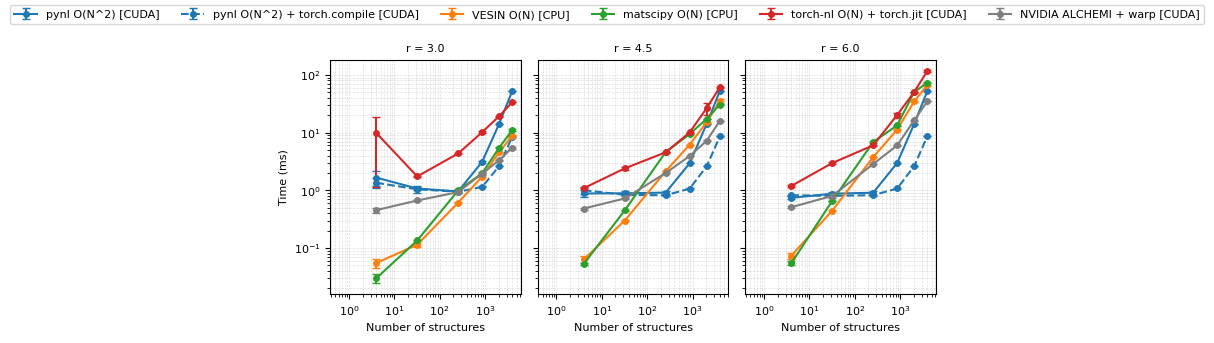

In [13]:
methods = [
    "pynl_on2",
    "pynl_on2_compile",
    "vesin_on1",
    "matscipy_on1",
    "torch_on1",
    "nvidia_on1",
]

labels = {
    "pynl_on2":         "pynl O(N^2) [CUDA]",
    "pynl_on2_compile": "pynl O(N^2) + torch.compile [CUDA]",
    "vesin_on1":        "VESIN O(N) [CPU]",
    "matscipy_on1":     "matscipy O(N) [CPU]",
    "torch_on1":        "torch-nl O(N) + torch.jit [CUDA]",
    "nvidia_on1":       "NVIDIA ALCHEMI + warp [CUDA]",
}

# One color per method family (pynl_on2 + pynl_on2_compile share color)
colors = {
    "pynl_on2":     "tab:blue",
    "vesin_on1":    "tab:orange",
    "matscipy_on1": "tab:green",
    "torch_on1":    "tab:red",
    "nvidia_on1":   "tab:grey",
}

radii_list = list(results.keys())
num_panels = len(radii_list)

fig, axes = plt.subplots(
    1,
    num_panels,
    sharex=True,
    sharey=True,
    figsize=(3.41 * 2, 3.41),
)

if num_panels == 1:
    axes = [axes]

for ax, radius in zip(axes, radii_list):

    # x-axis = number of structures
    n_struct_list = sorted(results[radius].keys())

    for method in methods:

        means  = [results[radius][n][method]["mean"]   for n in n_struct_list]
        errors = [results[radius][n][method]["stderr"] for n in n_struct_list]

        # Color by family: pynl_on2 + pynl_on2_compile → "pynl_on2"
        if method.startswith("pynl_on2"):
            color_key = "pynl_on2"
        else:
            color_key = method

        color = colors[color_key]
        linestyle = "--" if "compile" in method else "-"

        ax.errorbar(
            n_struct_list,
            means,
            yerr=errors,
            marker="o",
            linestyle=linestyle,
            color=color,
            capsize=3,
            label=labels[method],
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"r = {radius}")
    ax.grid(True, which="both", ls="--", alpha=0.4)

for ax in axes:
    ax.set_xlabel("Number of structures")
axes[0].set_ylabel("Time (ms)")

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc="upper center", ncol=len(methods))

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
